# DTSA 5511 Sentiment Analysis of Drug Reviews Project

The goal is to identify a Deep Learning problem to perform EDA and model analysis.

## Project Topic

Patient-centered care relies heavily on understanding user experience and satisfaction with medications. This project aims to develop a sentiment analysis model that automatically extracts overall satisfaction sentiment from user reviews of drugs. This will empower healthcare providers to gain valuable insights into patient perspectives and improve care delivery.

Our Approach:

Two powerful deep learning techniques are evaluated for this task: Recurrent Neural Networks (RNNs) and Bidirectional Encoder Representations from Transformers (BERT). RNNs excel at capturing context and sentiment by processing reviews sequentially, considering the relationships between words. BERT, a Transformer model, takes this a step further by simultaneously considering a word's context in both directions (bidirectional). This allows for a deeper understanding of word relationships, leading to potentially more accurate sentiment analysis, especially for complex reviews.

In [1]:
# Install Missing Libraries
import os

try:
  from ucimlrepo import fetch_ucirepo
  import ktrain
  from ktrain import text
  from ktrain.text import texts_from_df
except:
  !pip install ucimlrepo
  !pip install ktrain
  os.kill(os.getpid(), 9)

In [2]:
##### added line to ensure plots are showing
%matplotlib inline
#####

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sea
import warnings
import pickle

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from time import time

In [3]:
# Mounting google drive to store the best models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The Dataset

This is a public dataset published in the *UC Irving Machinel Learning Repository*. It provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites.

* Dataset Characteristics: Multivariate, Text
* Subject Area: Health and Medicine
* Instances: 215,063
* Features: 6
* Donated on: 10/3/2018

UCI Source: https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

In [4]:
# fetch dataset from the UCI repository
drug_reviews_drugs_com = fetch_ucirepo(id=462)

# fetch data as pandas dataframe
df_data = drug_reviews_drugs_com.data.features

## Exploratory Data Analysis

We'll initiate the model development process with a thorough data exploration phase. This includes inspecting, visualizing, and cleaning the data to prepare it for training.

### Visualizing the Dataset

Let's visualize the datase structure.

In [5]:
# print first 5 rows of the dataframe
df_data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [6]:
# size of the dataframe
df_data.shape

(215063, 6)

### Feature Variables

Next, let's take a look at the feature variables and target variable within the datasets.

In [7]:
# print information about the dataframe
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     215063 non-null  object
 1   condition    213869 non-null  object
 2   review       215063 non-null  object
 3   rating       215063 non-null  int64 
 4   date         215063 non-null  object
 5   usefulCount  215063 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 9.8+ MB


From the structure of the dataframe, we can observe:

* There is no missing values.
* feature variables `date` and `usefulCount` don't hold information relevant to the objective of this analysis.

### Dimensionality Reduction

First, let's remove the feature variables without predictive power.

In [8]:
warnings.filterwarnings('ignore')
# drop 'date' and 'usefulCount' feature variables
df_data.drop(columns=['date', 'usefulCount'], inplace=True)
df_data.head()

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9


Next, let's evaluate how many reviews per drug.

In [9]:
# print how many unique drugs are present in the data
df_drugs = pd.DataFrame(df_data['drugName'].value_counts(), columns=['count'])
df_drugs

,count
drugName,
Levonorgestrel,4930
Etonogestrel,4421
Ethinyl estradiol / norethindrone,3753
Nexplanon,2892
Ethinyl estradiol / norgestimate,2790
...,...
Excedrin Quick Tab,1
Bioflavonoids / zinc glycinate,1
Abstral,1


There are 3,671 unique drugs in the dataset, few with only one review. Let's determine how many drugs with more than 100 reviews.

In [10]:
# number of reviews for drugs with more than 100 reviews
df_drugs[df_drugs['count']<=100]['count'].sum()

44146

There are 44,146 drugs with equal or less than 100 reviews.

Drugs with very few reviews are more susceptible to noise, we will remove those drugs with few reviews from the dataset.

In [11]:
# remove those drugs with equal or less than 100 user reviews
df_data = df_data[df_data['drugName'].isin(df_drugs[df_drugs['count']>100].index)]
df_data

,drugName,condition,review,rating
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1
...,...,...,...,...
215056,Microgestin Fe 1 / 20,Birth Control,"""I was on Microgestin for about 3 years. Over ...",6
215057,Apri,Birth Control,"""I started taking Apri about 7 months ago. My ...",9
215059,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9
215060,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8


### Duplicated Instances

Let's check for duplicated user reviews within the dataset.

In [12]:
# check for duplicated instances in the dataset
df_data.duplicated().value_counts()

False    170858
True         59
Name: count, dtype: int64

There are 74 duplicated instances in the dataset.

Let's observe few of those to reconfirm the finding.

In [13]:
# print the first 4 duplicated instances
df_data[df_data.duplicated(keep=False)].sort_values(by=['drugName', 'condition','review']).head(8)

,drugName,condition,review,rating
191371,Acetaminophen / hydrocodone,Back Pain,"""Good.""",10
207868,Acetaminophen / hydrocodone,Back Pain,"""Good.""",10
131708,Acetaminophen / hydrocodone,Cough,"""Works great.""",10
176785,Acetaminophen / hydrocodone,Cough,"""Works great.""",10
124844,Alprazolam,Anxiety,"""For several years I have been prescribed 1mg ...",10
158494,Alprazolam,Anxiety,"""For several years I have been prescribed 1mg ...",10
124667,Alprazolam,Anxiety,"""Helps me a lot.""",10
164842,Alprazolam,Anxiety,"""Helps me a lot.""",10


Now, let's remove them from the dataset.

In [14]:
warnings.filterwarnings('ignore')
# check for duplicated Tweets in test set
df_data.drop_duplicates(keep='first', inplace=True)
df_data.shape

(170858, 4)

### Target Variable

Let's define our target variable adjusted to our specific goals and the level of detail required for our analysis.

In [15]:
# number of ratings in the rating variable
df_data['rating'].value_counts()

rating
10    51974
9     29236
1     23115
8     20186
7     10224
5      8880
2      7592
3      7202
6      6913
4      5536
Name: count, dtype: int64

We will segregate the rating into `satisfied` and `unsatisfied` categories. Segregating the ratings into these 2 categories will simplify the task for the models and potentially improves their accuracy. Moreover, the results will be easier to interpret and communicate.

In [16]:
warnings.filterwarnings('ignore')
# segregate the rating by categories: satisfied[>=6], unsatisfied[<=5]
or_labels = ['unsatisfied', 'satisfied']
df_data['satisfaction'] = pd.cut(df_data['rating'], bins=[0, 5, 10], labels=or_labels)
df_data['satisfaction'].value_counts()

satisfaction
satisfied      118533
unsatisfied     52325
Name: count, dtype: int64

### Data Distribution Analysis

Let's understand how the data is spread out and identify potential patterns or anomalies.

#### Review Word Count

Let's calculate the word count for each user review in the dataset.

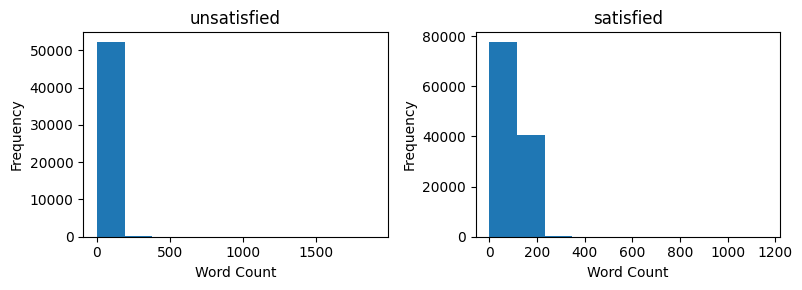

In [17]:
# Calculate the word count for each user review
df_review = df_data.copy()
df_review['words'] = df_review['review'].apply(lambda x: len(x.split()))

# number of plots
n = len(or_labels)
fig, ax = plt.subplots(1,n, figsize=(n*4,3))

for i in range(n):
  # hist chart
  plt.subplot(1,n,i+1)
  df_review[df_review['satisfaction']==or_labels[i]]['words'].plot(kind='hist')
  plt.title(or_labels[i])
  plt.ylabel('Frequency')
  plt.xlabel('Word Count')

fig.tight_layout(h_pad=20)
plt.show()

From the plots, we can observe that most of review word counts are between few words to 300 words. Short reviews may provide less context for the model to understand the sentiment or meaning, and long ones may be a problem during encoding. Therefore, we will remove those review with less than 10 words or with more than 200 words.

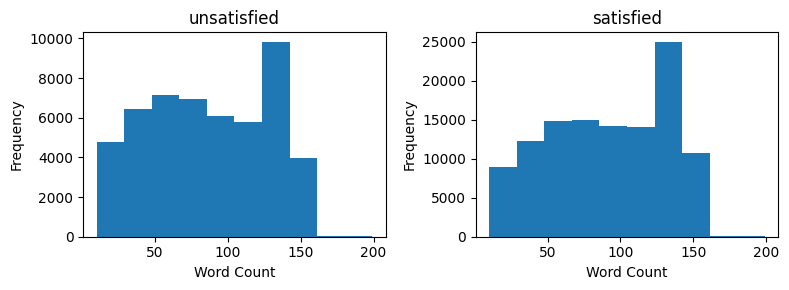

In [18]:
# number of plots
n = len(or_labels)
fig, ax = plt.subplots(1,n, figsize=(n*4,3))

for i in range(n):
  # hist chart
  plt.subplot(1,n,i+1)
  df_review[df_review['words']<=200][df_review['words']>=10][df_review['satisfaction']==or_labels[i]]['words'].plot(kind='hist')
  plt.title(or_labels[i])
  plt.ylabel('Frequency')
  plt.xlabel('Word Count')

fig.tight_layout(h_pad=20)
plt.show()

In [19]:
df_data_cl = df_review[df_review['words']<=200][df_review['words']>=10]
df_data_cl.shape

(166367, 6)

#### Target Variable Distribution

Next, let's take a look at the target variable distribution.

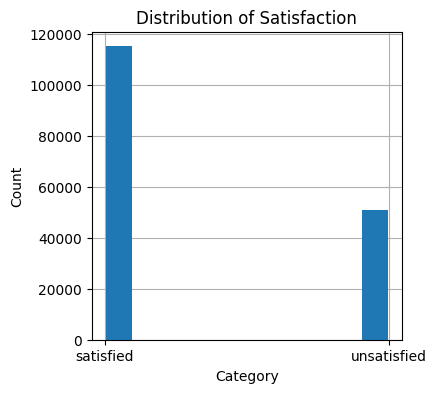

In [20]:
# plot a histogram of the users rating
df_data_cl['satisfaction'].hist(figsize=(4,4), zorder=2, rwidth=0.9)
plt.title('Distribution of Satisfaction')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

From the histogram, we can observe a concerning issue of class imbalace in the dataset. A predictive model trained on imbalance data might be biased towards the majority class. Therefore, to address this issue, we will apply an undersampling technique to decrease the number of data points in the majority class.

In [21]:
# transfering the minority class instances
df_data_bal = df_data_cl[df_data_cl['satisfaction']=='unsatisfied']
# number of sample for minority class
sample = df_data_bal.shape[0]

# add a random sample of the majority class
df_data_bal = pd.concat([df_data_bal, df_data_cl[df_data_cl['satisfaction']=='satisfied'].sample(n=sample, replace=False, random_state=42)])

In [22]:
# recheck the target variable distribution
df_data_bal['satisfaction'].value_counts()

satisfaction
unsatisfied    51096
satisfied      51096
Name: count, dtype: int64

Now, we have got a balanced dataset.

### Features Importance

Now, we will employ a Bag-of-Words (BoW) approach to represent each review as a vector where each element corresponds to a word in the vocabulary. The weight of each word in the vector will be determined using Tf-idf (Term Frequency-Inverse Document Frequency). Tf-idf emphasizes the importance of words that appear frequently within a document (review) but are rare across the entire corpus of reviews. This allows us to identify which keywords are most discriminative for each sentiment class.

In [23]:
# compute size of data
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

# vectorize the text
def vectorize_dataset(text_var, data_set, max_df=0.9, min_df=0.1, max_features=None, norm=None,
                      strip_accents='ascii', stop_words='english', lowercase=True, verbose=True):
    """Load and vectorize the dataset."""

    # Setup vectorizer
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features,
                                 norm=norm, strip_accents=strip_accents, stop_words=stop_words, lowercase=True)

    # Fit vectorizer with all texts from train, valid and test sets
    t0 = time()
    tfidf = vectorizer.fit_transform(data_set[text_var])
    duration_vctzr = time() - t0

    # Get vectorized feature names
    feature_names = vectorizer.get_feature_names_out()

    # Print information of the pre-processing
    if verbose:
        # compute size of loaded data
        data_vctzr_size_mb = size_mb(data_set[text_var])

        # print size of datasets
        print(f"{len(data_set[text_var])} documents - "
              f"{data_vctzr_size_mb:.2f}MB (dataset)")

        print(f"vectorizer learning done in {duration_vctzr:.3f}s "
              f"at {(data_vctzr_size_mb) / duration_vctzr:.3f}MB/s")
        print(f"n_samples: {tfidf.shape[0]}, n_features: {tfidf.shape[1]}")

    return tfidf, feature_names

In [24]:
# vectorize the text data
tfidf_review, feature_names = vectorize_dataset('review', df_data_bal, max_df=.6, min_df=0, norm='l2',
                              strip_accents='unicode', stop_words='english', lowercase=True, verbose=True)

102192 documents - 49.29MB (dataset)
vectorizer learning done in 5.835s at 8.448MB/s
n_samples: 102192, n_features: 39251


Our Tf-idf vectorization resulted in a high number of features (39,251) due to the wide inclusion of words.

In [25]:
# function to plot top 20 features by mean Tf-idf weight across the dataset
def top_words(feature_names, X_tfidf, y, labels):
  df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

  # reset index
  y_reset =  y.reset_index(drop=True)

  # number of plots
  n = len(labels)
  #print(np)

  fig, ax = plt.subplots(1,n, figsize=(n*6,4))
  for i in range(n):
    # search indexes for each class
    idx = list(y_reset[y_reset==labels[i]].index)

    # Sort feature names by TF-IDF scores
    word = df_tfidf.iloc[idx].mean(axis=0).sort_values(ascending=False)

    # Bar chart
    plt.subplot(1,n,i+1)
    word[:20].plot(kind='bar')
    plt.title(f'label: {labels[i]}')
    plt.ylabel('TF-IDF Mean Score')
    plt.xlabel('Keyword')

  fig.tight_layout(h_pad=20)
  plt.show()

Let's visualize the top 20 keywords which are the most discriminative for each sentiment class.

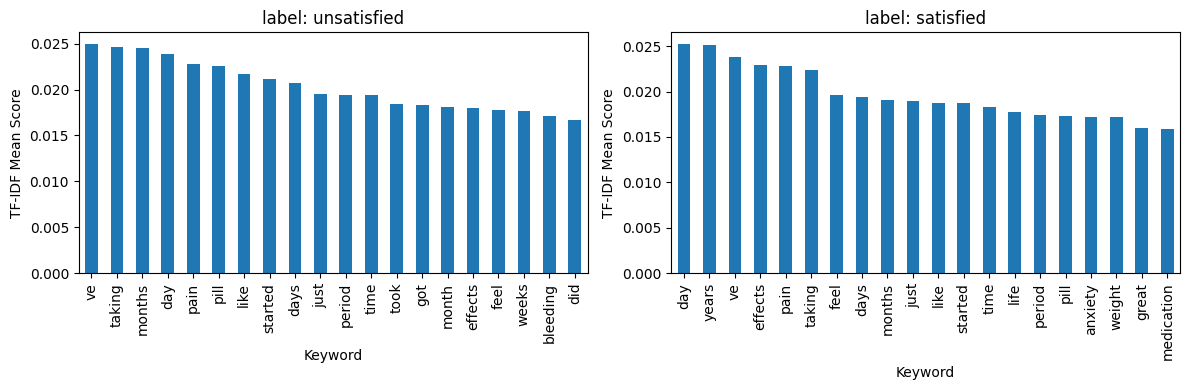

In [26]:
# plot top 20 keywords which are the most discriminative for each sentiment class
top_words(feature_names, tfidf_review, df_data_bal['satisfaction'], or_labels)

The plots revealed a limited association between specific keywords and user satisfaction. This suggests that sentiment in these reviews is likely conveyed through more nuanced language and the relationships between words, rather than relying solely on the presence or absence of isolated keywords. Consequently, for our machine learning model selection, we should prioritize algorithms that excel at capturing these contextual relationships within the review text.

## Model Building and Training

This section involves the building, specifically focusing on Recurrent Neural Networks (RNNs) and pre-trained models like BERT, and training of the predictive models. We will explore different architectures and hyperparameters to optimize the model's ability to capture the context within user reviews and identify features that express user sentiment about drug satisfaction.



### Prepare the Data

Before proceeding to the model building, we will prepare the data. This involves concatenating the `condition` and `review` features to ensure capturing the sentiments by type of drug, and one-hot encoding the target variable.

In [27]:
# concatenate the 'condition' and 'review'
df_data_bal['text'] = df_data_bal['condition'] + ' ' + df_data_bal['review']

# one-hot encode the target variable for RNNs
df_data_bal['target'] = df_data_bal['satisfaction'].map({'unsatisfied': 0, 'satisfied': 1})
df_data_bal.head()

,drugName,condition,review,rating,satisfaction,words,text,target
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,unsatisfied,68,"Benign Prostatic Hyperplasia ""2nd day on 5mg s...",0
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,unsatisfied,30,"Emergency Contraception ""He pulled out, but he...",0
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,unsatisfied,35,"Epilepsy "" I Ve had nothing but problems with...",0
13,Dextromethorphan,Cough,"""Have a little bit of a lingering cough from a...",4,unsatisfied,110,"Cough ""Have a little bit of a lingering cough ...",0
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,unsatisfied,145,"Birth Control ""Started Nexplanon 2 months ago ...",0


Finally, we will split the dataset into a `train` set and a `test` set. These datasets will contain only the required field for training the models.

In [28]:
# split the 'df_train_bal' into training / validation
df_train, df_test = train_test_split(df_data_bal[['text','target','satisfaction']], test_size=0.2, stratify=df_data_bal.satisfaction, random_state=42)

In [29]:
# print size of train and test set
print(f'Training set: {df_train.shape}')
print(f'Test set: {df_test.shape}')
df_train.head()

Training set: (81753, 3)
Test set: (20439, 3)


,text,target,satisfaction
176048,"Urticaria ""I have had CIU for over 13 years wi...",1,satisfied
33492,"Birth Control ""Very effective in the purpose. ...",0,unsatisfied
5798,"Anxiety ""worked great when I started...a year ...",1,satisfied
24352,"2</span> users found this comment helpful. ""I ...",1,satisfied
67795,"ibromyalgia ""Great for getting a good nights s...",1,satisfied


### Validation Metric Convergence Tracker

To gain insights into the training process, let's define a function to visualize how model performance metrics, such as the validation loss function, converge over epochs.

In [30]:
# Plot metrics vs epoch
def history_plot(model):
    # initiate dict
    hist_dict = {}
    # iterate across each metric
    for metric in model.history.keys():
        # extract metric values
        hist_dict[metric] = model.history[metric]

    # range of epoch
    epoch_range = range(1, len(hist_dict['loss'])+1)

    # number of sub-plots
    n = int(len(hist_dict.keys())/2)

    # set plot size
    plt.figure(figsize=[n*4,4])

    # iterate across number of sub-plots
    for i in range(n):
        # metric
        metric = list(hist_dict.keys())[i]
        # plot metric values
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, hist_dict[metric], label='Training')
        plt.plot(epoch_range, hist_dict['val_' + metric], label='Validation')
        plt.xlabel('epoch'); plt.ylabel(metric); plt.title(f'Convergence of {metric}')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

### Recurrent Neural Networks (RNNs)

To leverage the strengths of Long Short-Term Memory (LSTM) networks in capturing sequential information within user reviews, we will explore various RNN architectures utilizing LSTM layers.

We will begin with a baseline model that consists of:

* A `TextVectorization` layer which maps text features to integer sequences.
* An `Embedding` layer that converts each word into a fixed length vector of defined size.
* Two (2) `LSTM` layers to handle the sequence of words, where the output from the previous step is fed as input to the current step.
* A `Dense` layer with a `sigmoid` activation function that act as a classifier.

After establishing a baseline model, we will refine its performance through hyperparameter tuning. This process will involve systematically adjusting parameters like embedding size, number of LSTM layers, the use of bidirectional layers, and the strength of regularization to achieve optimal sentiment analysis accuracy on user reviews.

To optimize the training process, we will employ a learning rate schedule with exponential decay, utilize model checkpointing based on `validation auc`, and implement early stopping to prevent overfitting and save training time.

#### Data Transformation

For training our RNN models, we will leverage word embeddings. Word embeddings represent words as vectors in a high-dimensional space, allowing the model to learn semantic relationships between words and improve its understanding of user reviews.

In [31]:
# convert pd dataframes to tf datasets
# tf datasets
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

tf_train = tf.data.Dataset.from_tensor_slices((df_train['text'], df_train['target']))
tf_test = tf.data.Dataset.from_tensor_slices((df_test['text'], df_test['target']))

# split the train and valid data into batches of 32
batch_size = 32
tf_train = tf_train.batch(batch_size)
tf_test = tf_test.batch(batch_size)

# print one example for the tf train set
example, label = next(iter(tf_train))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'Urticaria "I have had CIU for over 13 years without remission.  Horrible, painful, debilitating hives that grow for days before receding. I&#039;ve never gone more than a couple of days without at least one hive, despite mega-doses of antihistamines and other doctor recommended medications. I&#039;d tried it all!  I received my first injection of Xolair 26 days ago and have not had one single hive! This medicine is, so far, the miracle I have been hoping and searching for, for 13 long years!"'

Label:  1


In [32]:
# Determine number of batches per set
tf_train_batch = len(tf_train)
tf_test_batch = len(tf_test)

print('Number of batches')
print('train / test')
print(tf_train_batch, '/', tf_test_batch)

Number of batches
train / test
2555 / 639


Leveraging the insights from Exploratory Data Analysis (EDA), our `TextVectorization` layer will be configured with a `vocabulary size` of 50,000 words. Additionally, to enhance model efficiency, we will cap the maximum review length at 120 words.

In [33]:
# set length of the encoder output vector to 200 words
max_length = 120

# set TextVectorization layer to normalize, split, and map strings to integers
encoder = TextVectorization(max_tokens=50000,
                            standardize='lower_and_strip_punctuation',
                            split='whitespace',
                            output_mode='int',
                            output_sequence_length=max_length,
                            )

# adapt the TextVectorization layer to the training data.
encoder.adapt(tf_train.map(lambda text, _: text))

# calculate vocabulary size
vocab_size = len(encoder.get_vocabulary())

**Note**: We experimented with various maximum review lengths (120, 150, 170, 200 words) to optimize model efficiency. However, lengths above 120 words hindered the model's learning ability, resulting in stalling after a few epochs.

Let's test the encoder layer with the example from train set.

In [34]:
# extracting the vocabulary from the TextVectorization layer
vocabulary = np.array(encoder.get_vocabulary())

# encoding a test example and decoding it back
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'Urticaria "I have had CIU for over 13 years without remission.  Horrible, painful, debilitating hives that grow for days before receding. I&#039;ve never gone more than a couple of days without at least one hive, despite mega-doses of antihistamines and other doctor recommended medications. I&#039;d tried it all!  I received my first injection of Xolair 26 days ago and have not had one single hive! This medicine is, so far, the miracle I have been hoping and searching for, for 13 long years!"'
encoded:  [ 2711     2    12    17 14746     9   107   864    53   226  3537   169
   289  1299  1168    20  2695     9    49    83  8333    39    93   264
    78   109     8   290    11    49   226    25   390    79  6307  1089
 25552    11  5322     3   118    87   569   471   383   140     7    36
     2  1232     6    41   664    11  5209  1509    49   132     3    12
    22    17    79   763  6307    13   121    19    23   187     4   564
     2    12    24   459     3  3150    

#### Model Training Settings

To enhance the efficiency and effectiveness of our training process, we'll utilize a learning rate schedule with exponential decay. This strategy facilitates faster initial convergence and then gradually reduces the learning rate for fine-tuning later in training.

Additionally, we'll implement early stopping with AUC (Area Under the ROC Curve) as the monitoring metric. AUC ensures the model doesn't become biased towards a specific class (satisfied or unsatisfied).

In [35]:
# learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                              initial_learning_rate=1e-2,
                              decay_steps=tf_train_batch,
                              decay_rate=0.90,
                              staircase=True
                              )

# Set an early stopper
stopper = keras.callbacks.EarlyStopping(
                              monitor="val_auc",
                              min_delta=0,
                              patience=0,
                              verbose=0,
                              mode="auto",
                              baseline=None,
                              restore_best_weights=False,
                              start_from_epoch=10,
                              )

#### Baseline Architecture

In [36]:
# clear keras backend
tf.keras.backend.clear_session()

# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_bs_RNN = Sequential([
                encoder,
                Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
                LSTM(128, return_sequences=True),
                LSTM(64),
                Dense(1, activation='sigmoid')
                ])

# Summary of the model
mdl_bs_RNN.summary()

# Compile the model
mdl_bs_RNN.compile(
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy', keras.metrics.AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 120, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6581057 (25.10 MB)
Trainable params: 6581057 (25.10 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [37]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                        filepath = '/content/drive/MyDrive/W6_mdl_bs_RNN_weights_best.keras',
                        monitor='val_auc',
                        mode='max',
                        verbose = 1,
                        save_best_only=True
                        )

# Training the model
hist_bs_RNN = mdl_bs_RNN.fit(
                        tf_train,
                        steps_per_epoch = tf_train_batch,
                        epochs = 30,
                        validation_data = tf_test,
                        validation_steps = tf_test_batch,
                        verbose = 1,
                        callbacks=[checkpointer, stopper]
                        )

# calculate wall time
dur_bs_RNN = time() - t0

Epoch 1/30
2553/2555 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.6742 - auc: 0.7496
Epoch 1: val_auc improved from -inf to 0.84344, saving model to /content/drive/MyDrive/W6_mdl_bs_RNN_weights_best.keras
2555/2555 [==============================] - 70s 26ms/step - loss: 0.5883 - accuracy: 0.6743 - auc: 0.7497 - val_loss: 0.4941 - val_accuracy: 0.7677 - val_auc: 0.8434
Epoch 2/30
2552/2555 [============================>.] - ETA: 0s - loss: 0.4611 - accuracy: 0.7853 - auc: 0.8643
Epoch 2: val_auc improved from 0.84344 to 0.86779, saving model to /content/drive/MyDrive/W6_mdl_bs_RNN_weights_best.keras
2555/2555 [==============================] - 40s 15ms/step - loss: 0.4611 - accuracy: 0.7853 - auc: 0.8643 - val_loss: 0.4595 - val_accuracy: 0.7872 - val_auc: 0.8678
Epoch 3/30
2552/2555 [============================>.] - ETA: 0s - loss: 0.4210 - accuracy: 0.8086 - auc: 0.8888
Epoch 3: val_auc improved from 0.86779 to 0.87883, saving model to /content/drive/MyDri

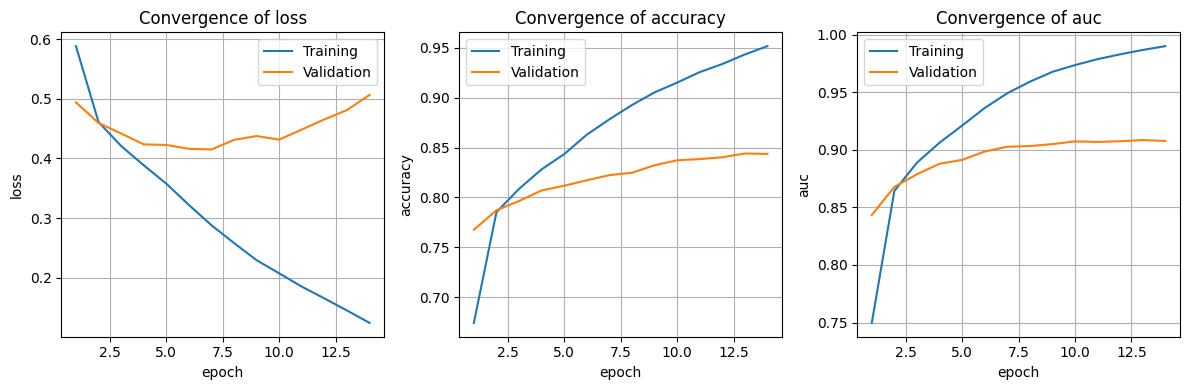

In [38]:
# monitor training convergence
history_plot(hist_bs_RNN)

The validation loss curve suggests overfitting after epoch 7, indicated by the sharp rise. This suggests the model may be memorizing specific training examples, particularly from one class. While overall accuracy may increase, the flat AUC indicates the model isn't generalizing well to unseen data and struggling to differentiate between `satisfied` and `unsatisfied` reviews.

The best performing model based on the `validation AUC` was saved at epoch 13, with a `validation accuracy` of 84.41%.

#### Hyperparameters Tuning

Leveraging insights from the baseline model's performance, we will conduct hyperparameter tuning to optimize its efficiency and potentially enhance its accuracy.

##### H1 - Dropout Regularization to 1st LSTM Layer (rate=0.1)

To prevent overfitting and encourage the model to learn generalizable patterns from sequential data, we will employ `dropout` regularization within the `LSTM` layer with the `return_sequences` parameter set to `True`. This technique specifically targets overfitting in sequence tasks by randomly dropping out entire hidden states during training. We will commence by applying a conservative dropout rate of 0.1.

In [44]:
# clear keras backend
tf.keras.backend.clear_session()

# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_h1_RNN = Sequential([
                encoder,
                Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
                LSTM(128, return_sequences=True, dropout=0.1),
                LSTM(64),
                Dense(1, activation='sigmoid')
                ])

# Summary of the model
mdl_h1_RNN.summary()

# Compile the model
mdl_h1_RNN.compile(
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['accuracy', keras.metrics.AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 120, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6581057 (25.10 MB)
Trainable params: 6581057 (25.10 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [45]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                          filepath = '/content/drive/MyDrive/W6_mdl_h1_RNN_weights_best.keras',
                          monitor='val_auc',
                          mode='max',
                          verbose = 1,
                          save_best_only=True
                          )

# Training the model
hist_h1_RNN = mdl_h1_RNN.fit(
                          tf_train,
                          steps_per_epoch = tf_train_batch,
                          epochs = 30,
                          validation_data = tf_test,
                          validation_steps = tf_test_batch,
                          verbose = 1,
                          callbacks=[checkpointer, stopper]
                          )

# calculate wall time
dur_h1_RNN = time() - t0

Epoch 1/30
2552/2555 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.7181 - auc: 0.8002
Epoch 1: val_auc improved from -inf to 0.85889, saving model to /content/drive/MyDrive/W6_mdl_h1_RNN_weights_best.keras
2555/2555 [==============================] - 71s 26ms/step - loss: 0.5415 - accuracy: 0.7182 - auc: 0.8002 - val_loss: 0.4704 - val_accuracy: 0.7812 - val_auc: 0.8589
Epoch 2/30
2553/2555 [============================>.] - ETA: 0s - loss: 0.4381 - accuracy: 0.7989 - auc: 0.8787
Epoch 2: val_auc improved from 0.85889 to 0.87352, saving model to /content/drive/MyDrive/W6_mdl_h1_RNN_weights_best.keras
2555/2555 [==============================] - 41s 16ms/step - loss: 0.4381 - accuracy: 0.7990 - auc: 0.8787 - val_loss: 0.4489 - val_accuracy: 0.7927 - val_auc: 0.8735
Epoch 3/30
2554/2555 [============================>.] - ETA: 0s - loss: 0.4054 - accuracy: 0.8181 - auc: 0.8973
Epoch 3: val_auc improved from 0.87352 to 0.88115, saving model to /content/drive/MyDri

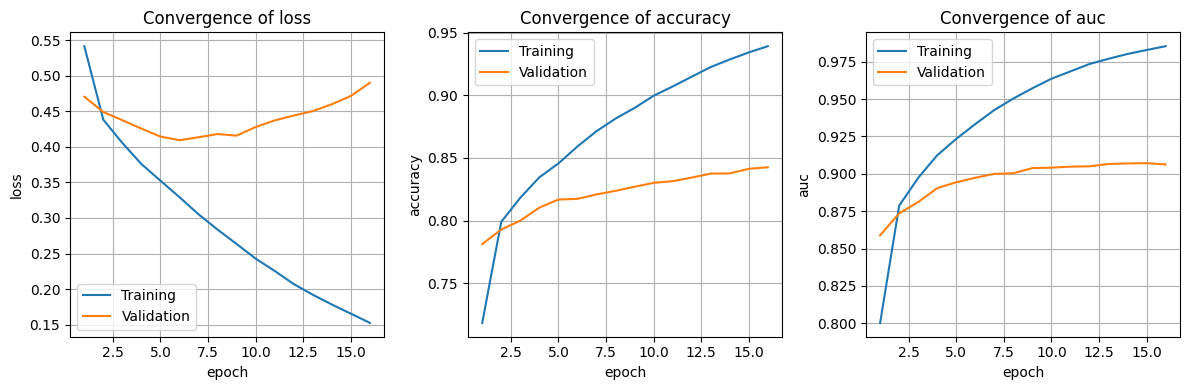

In [46]:
# monitor training convergence
history_plot(hist_h1_RNN)

The validation loss curve suggests current dropout setup may not be effectively mitigating overfitting.

Furthermore, the model slightly underperformed the baseline model overall performance.

##### H2 - Dropout Regularization to LSTM Layers (rate=0.1)

Since the previous dropout setup did not yield a significant improvement in model overfitting, we will explore the application of dropout regularization within all LSTM layers instead. This alternative technique might help mitigate overfitting and potentially enhance model generalizability.

In [39]:
# clear keras backend
tf.keras.backend.clear_session()

# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_h2_RNN = Sequential([
                encoder,
                Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
                LSTM(128, return_sequences=True, dropout=0.1),
                LSTM(64, dropout=0.1),
                Dense(1, activation='sigmoid')
                ])

# Summary of the model
mdl_h2_RNN.summary()

# Compile the model
mdl_h2_RNN.compile(
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['accuracy', keras.metrics.AUC()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 120, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6581057 (25.10 MB)
Trainable params: 6581057 (25.10 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [40]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                          filepath = '/content/drive/MyDrive/W6_mdl_h2_RNN_weights_best.keras',
                          monitor='val_auc',
                          mode='max',
                          verbose = 1,
                          save_best_only=True
                          )

# Training the model
hist_h2_RNN = mdl_h2_RNN.fit(
                          tf_train,
                          steps_per_epoch = tf_train_batch,
                          epochs = 30,
                          validation_data = tf_test,
                          validation_steps = tf_test_batch,
                          verbose = 1,
                          callbacks=[checkpointer, stopper]
                          )

# calculate wall time
dur_h2_RNN = time() - t0

Epoch 1/30
2553/2555 [============================>.] - ETA: 0s - loss: 0.7001 - accuracy: 0.4991 - auc: 0.4976
Epoch 1: val_auc improved from -inf to 0.50000, saving model to /content/drive/MyDrive/W6_mdl_h2_RNN_weights_best.keras
2555/2555 [==============================] - 71s 26ms/step - loss: 0.7001 - accuracy: 0.4991 - auc: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/30
2555/2555 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.4979 - auc: 0.4975
Epoch 2: val_auc did not improve from 0.50000
2555/2555 [==============================] - 40s 16ms/step - loss: 0.6985 - accuracy: 0.4979 - auc: 0.4975 - val_loss: 0.6939 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/30
2555/2555 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.4981 - auc: 0.4986
Epoch 3: val_auc did not improve from 0.50000
2555/2555 [==============================] - 41s 16ms/step - loss: 0.6975 - accuracy: 0.4981 - auc: 0.4986 - val_loss:

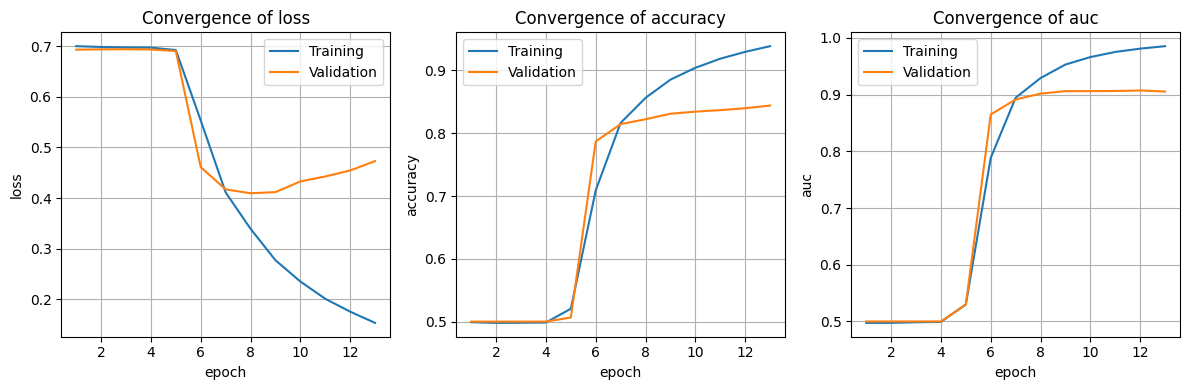

In [41]:
# monitor training convergence
history_plot(hist_h2_RNN)

The model's initial learning was slow, suggesting potential optimization challenges. This was addressed by the exponential decay of the learning rate, which likely helped the model escape local minima and find a better solution.

Consequently, the current dropout regularization rate (0.1) did not appear to significantly improve overfitting in this case compared to the baseline model.

##### H3 - Dropout Regularization to LSTM Layers (rate=0.2)

Since both previous dropout setups at 0.1 haven't yielded significant improvement in the model overfitting the training data, we will experiment with a higher dropout rate at 0.2 in the LSTM layers.

In [42]:
# clear keras backend
tf.keras.backend.clear_session()

# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_h3_RNN = Sequential([
                encoder,
                Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
                LSTM(128, return_sequences=True, dropout=0.2),
                LSTM(64, dropout=0.2),
                Dense(1, activation='sigmoid')
                ])

# Summary of the model
mdl_h3_RNN.summary()

# Compile the model
mdl_h3_RNN.compile(
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['accuracy', keras.metrics.AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 120, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6581057 (25.10 MB)
Trainable params: 6581057 (25.10 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [43]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                          filepath = '/content/drive/MyDrive/W6_mdl_h3_RNN_weights_best.keras',
                          monitor='val_auc',
                          mode='max',
                          verbose = 1,
                          save_best_only=True
                          )

# Training the model
hist_h3_RNN = mdl_h3_RNN.fit(
                          tf_train,
                          steps_per_epoch = tf_train_batch,
                          epochs = 30,
                          validation_data = tf_test,
                          validation_steps = tf_test_batch,
                          verbose = 1,
                          callbacks=[checkpointer, stopper]
                          )

# calculate wall time
dur_h3_RNN = time() - t0

Epoch 1/30
2553/2555 [============================>.] - ETA: 0s - loss: 0.5911 - accuracy: 0.6627 - auc: 0.7419
Epoch 1: val_auc improved from -inf to 0.84607, saving model to /content/drive/MyDrive/W6_mdl_h3_RNN_weights_best.keras
2555/2555 [==============================] - 70s 26ms/step - loss: 0.5910 - accuracy: 0.6628 - auc: 0.7420 - val_loss: 0.4920 - val_accuracy: 0.7679 - val_auc: 0.8461
Epoch 2/30
2553/2555 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.7892 - auc: 0.8670
Epoch 2: val_auc improved from 0.84607 to 0.87279, saving model to /content/drive/MyDrive/W6_mdl_h3_RNN_weights_best.keras
2555/2555 [==============================] - 41s 16ms/step - loss: 0.4572 - accuracy: 0.7893 - auc: 0.8670 - val_loss: 0.4491 - val_accuracy: 0.7897 - val_auc: 0.8728
Epoch 3/30
2554/2555 [============================>.] - ETA: 0s - loss: 0.4136 - accuracy: 0.8141 - auc: 0.8929
Epoch 3: val_auc improved from 0.87279 to 0.88535, saving model to /content/drive/MyDri

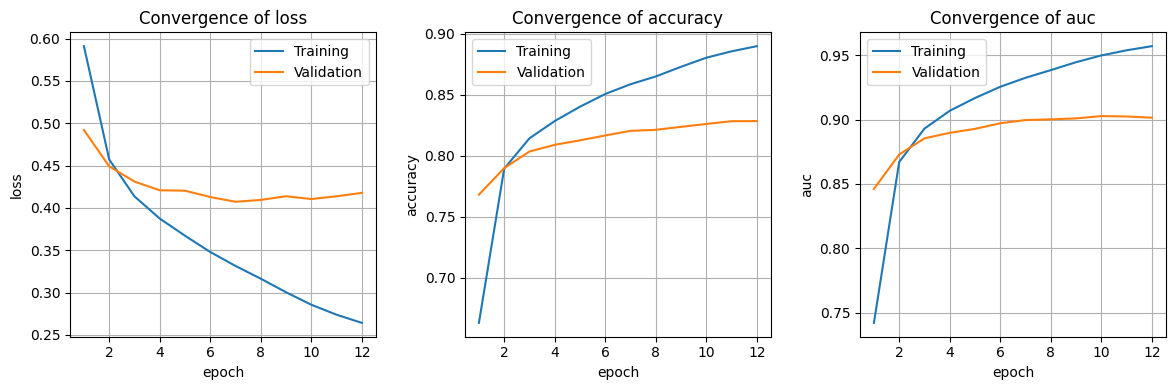

In [44]:
# monitor training convergence
history_plot(hist_h3_RNN)

The plots reveal that increasing the dropout rate mitigated the sharp rise in validation loss. However, this did not translate to a significant improvement in overall model performance, as evidenced by the stagnant AUC.

##### H4 - Dropout Regularization (rate=0.3)

Given the limited effectiveness of dropout rates at 0.1 and 0.2, we will cautiously experiment with a higher dropout rate of 0.3 in the LSTM layers. It's crucial to monitor the impact on both validation loss and AUC to ensure we don't hinder learning.

In [45]:
# clear keras backend
tf.keras.backend.clear_session()

# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_h4_RNN = Sequential([
                encoder,
                Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
                LSTM(128, return_sequences=True, dropout=0.3),
                LSTM(64, dropout=0.3),
                Dense(1, activation='sigmoid')
                ])

# Summary of the model
mdl_h4_RNN.summary()

# Compile the model
mdl_h4_RNN.compile(
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['accuracy', keras.metrics.AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 120, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6581057 (25.10 MB)
Trainable params: 6581057 (25.10 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [46]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                          filepath = '/content/drive/MyDrive/W6_mdl_h4_RNN_weights_best.keras',
                          monitor='val_auc',
                          mode='max',
                          verbose = 1,
                          save_best_only=True
                          )

# Training the model
hist_h4_RNN = mdl_h4_RNN.fit(
                          tf_train,
                          steps_per_epoch = tf_train_batch,
                          epochs = 30,
                          validation_data = tf_test,
                          validation_steps = tf_test_batch,
                          verbose = 1,
                          callbacks=[checkpointer, stopper]
                          )

# calculate wall time
dur_h4_RNN = time() - t0

Epoch 1/30
2552/2555 [============================>.] - ETA: 0s - loss: 0.5400 - accuracy: 0.7162 - auc: 0.8000
Epoch 1: val_auc improved from -inf to 0.86525, saving model to /content/drive/MyDrive/W6_mdl_h4_RNN_weights_best.keras
2555/2555 [==============================] - 71s 26ms/step - loss: 0.5399 - accuracy: 0.7163 - auc: 0.8001 - val_loss: 0.4662 - val_accuracy: 0.7816 - val_auc: 0.8653
Epoch 2/30
2555/2555 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.8059 - auc: 0.8846
Epoch 2: val_auc improved from 0.86525 to 0.88148, saving model to /content/drive/MyDrive/W6_mdl_h4_RNN_weights_best.keras
2555/2555 [==============================] - 42s 17ms/step - loss: 0.4282 - accuracy: 0.8059 - auc: 0.8846 - val_loss: 0.4478 - val_accuracy: 0.7924 - val_auc: 0.8815
Epoch 3/30
2552/2555 [============================>.] - ETA: 0s - loss: 0.3983 - accuracy: 0.8228 - auc: 0.9012
Epoch 3: val_auc improved from 0.88148 to 0.88925, saving model to /content/drive/MyDri

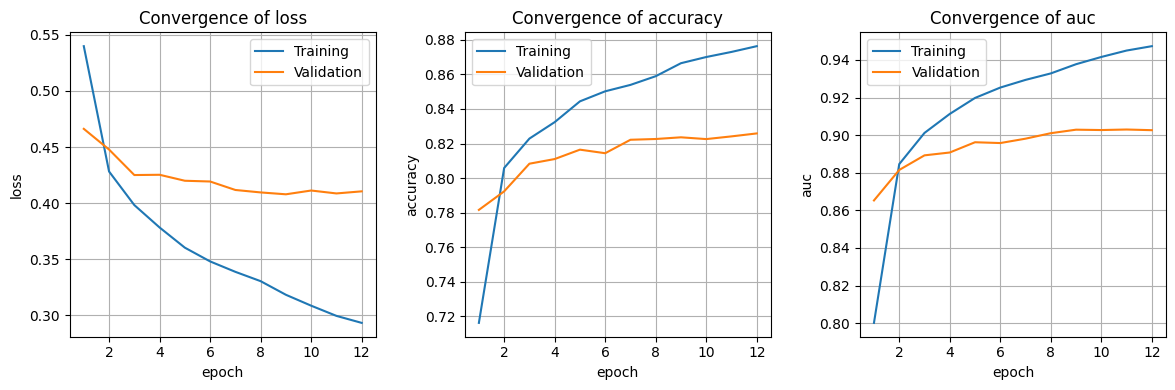

In [47]:
# monitor training convergence
history_plot(hist_h4_RNN)

The validation loss curve suggests that increasing the dropout regularization rate to 0.3 helped reduce overfitting. However, there wasn't a significant improvement in model accuracy.


##### H5 - Bidirectional LSTM Layers

Having achieved a well-controlled validation loss and a promising improvement in AUC and accuracy, we can now explore a more complex architecture involving bidirectional LSTM layers to potentially enhance model performance further. Bidirectional LSTM layers can leverage information from both past and future contexts in sequences, potentially leading to even better sentiment analysis capabilities.

In [48]:
# clear keras backend
tf.keras.backend.clear_session()

# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_h5_RNN = Sequential([
                encoder,
                Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
                Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)),
                Bidirectional(LSTM(64, dropout=0.3)),
                Dense(1, activation='sigmoid')
                ])

# Summary of the model
mdl_h5_RNN.summary()

# Compile the model
mdl_h5_RNN.compile(
            loss=keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['accuracy', keras.metrics.AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 128)          6400000   
                                                                 
 bidirectional (Bidirection  (None, 120, 256)          263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [49]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                          filepath = '/content/drive/MyDrive/W6_mdl_h5_RNN_weights_best.keras',
                          monitor='val_auc',
                          mode='max',
                          verbose = 1,
                          save_best_only=True
                          )

# Training the model
hist_h5_RNN = mdl_h5_RNN.fit(
                          tf_train,
                          steps_per_epoch = tf_train_batch,
                          epochs = 30,
                          validation_data = tf_test,
                          validation_steps = tf_test_batch,
                          verbose = 1,
                          callbacks=[checkpointer, stopper]
                          )

# calculate wall time
dur_h5_RNN = time() - t0

Epoch 1/30
2555/2555 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.6431 - auc: 0.6976
Epoch 1: val_auc improved from -inf to 0.82525, saving model to /content/drive/MyDrive/W6_mdl_h5_RNN_weights_best.keras
2555/2555 [==============================] - 101s 37ms/step - loss: 0.6293 - accuracy: 0.6431 - auc: 0.6976 - val_loss: 0.5174 - val_accuracy: 0.7504 - val_auc: 0.8252
Epoch 2/30
2554/2555 [============================>.] - ETA: 0s - loss: 0.4772 - accuracy: 0.7766 - auc: 0.8534
Epoch 2: val_auc improved from 0.82525 to 0.86809, saving model to /content/drive/MyDrive/W6_mdl_h5_RNN_weights_best.keras
2555/2555 [==============================] - 68s 27ms/step - loss: 0.4771 - accuracy: 0.7766 - auc: 0.8534 - val_loss: 0.4563 - val_accuracy: 0.7887 - val_auc: 0.8681
Epoch 3/30
2553/2555 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.8080 - auc: 0.8870
Epoch 3: val_auc improved from 0.86809 to 0.88350, saving model to /content/drive/MyDr

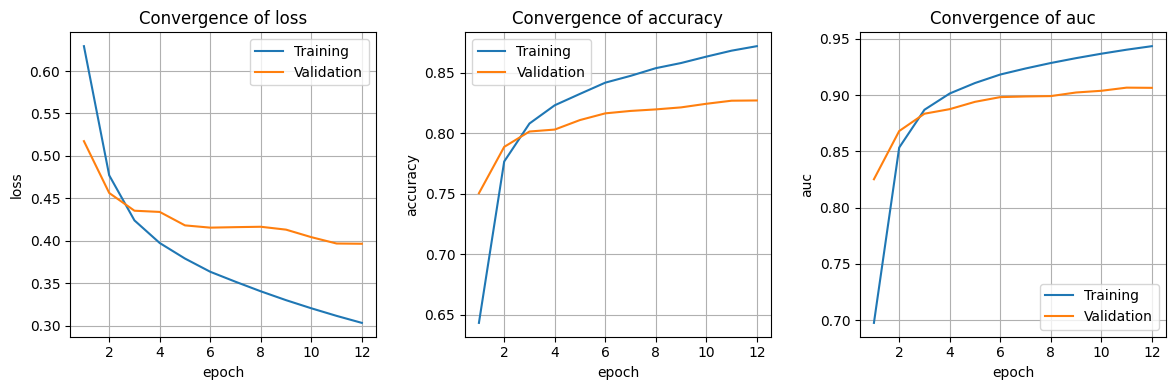

In [50]:
# monitor training convergence
history_plot(hist_h5_RNN)

Incorporating bidirectional layers appears to have enhanced the model's learning efficiency. This is evidenced by the validation loss decreasing at a rate comparable to the training loss, suggesting the model is effectively capturing information from the data. However, this improvement in learning hasn't translated into a significant boost in overall model performance compared to the baseline model.

##### Fine-Tuning the RNN Model

Having established the model's learning efficiency, we'll proceed with fine tuning the model training configuration to potentially unlock additional performance improvements.

In [51]:
# clear keras backend
tf.keras.backend.clear_session()

# define a ReduceLROnPlateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              verbose=0,
                              min_lr=0.00001,
                              )

# define an early stopper
stopper = keras.callbacks.EarlyStopping(
                              monitor="val_accuracy",
                              min_delta=0,
                              patience=5,
                              verbose=0,
                              mode="auto",
                              baseline=None,
                              restore_best_weights=False,
                              start_from_epoch=20,
                              )

In [52]:
# Load the best h5 model
mdl_h5ft_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_h5_RNN_weights_best.keras')

In [53]:
%%time
# Compile the model
mdl_h5ft_RNN.compile(
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                metrics=['accuracy', keras.metrics.AUC(name='auc')])

## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                          filepath = '/content/drive/MyDrive/W6_mdl_h5ft_RNN_weights_best.keras',
                          monitor='val_accuracy',
                          mode='max',
                          verbose = 1,
                          save_best_only=True
                          )

# Training the model
hist_h5ft_RNN = mdl_h5ft_RNN.fit(
                          tf_train,
                          steps_per_epoch = tf_train_batch,
                          epochs = 100,
                          validation_data = tf_test,
                          validation_steps = tf_test_batch,
                          verbose = 1,
                          callbacks=[checkpointer, stopper]
                          )

# calculate wall time
dur_h5ft_RNN = time() - t0

Epoch 1/100
2553/2555 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.8736 - auc: 0.9457
Epoch 1: val_accuracy improved from -inf to 0.82788, saving model to /content/drive/MyDrive/W6_mdl_h5ft_RNN_weights_best.keras
2555/2555 [==============================] - 100s 37ms/step - loss: 0.2978 - accuracy: 0.8736 - auc: 0.9457 - val_loss: 0.3946 - val_accuracy: 0.8279 - val_auc: 0.9081
Epoch 2/100
2555/2555 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8776 - auc: 0.9477
Epoch 2: val_accuracy improved from 0.82788 to 0.82979, saving model to /content/drive/MyDrive/W6_mdl_h5ft_RNN_weights_best.keras
2555/2555 [==============================] - 68s 26ms/step - loss: 0.2917 - accuracy: 0.8776 - auc: 0.9477 - val_loss: 0.3918 - val_accuracy: 0.8298 - val_auc: 0.9093
Epoch 3/100
2553/2555 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8804 - auc: 0.9497
Epoch 3: val_accuracy improved from 0.82979 to 0.83037, saving model 

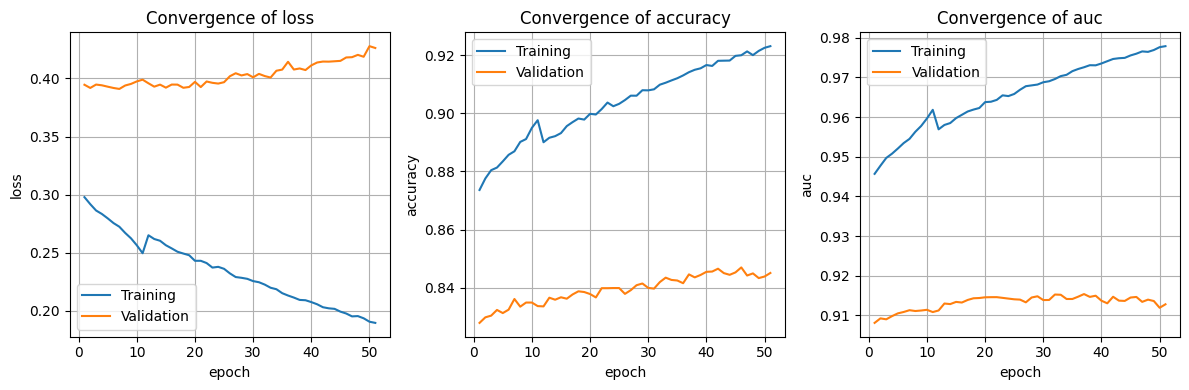

In [54]:
# monitor training convergence
history_plot(hist_h5ft_RNN)

With the overfitting effectively regulated, we managed to optimize the RNN model for a validation accuracy of 84.70% and a corresponding AUC of 91.47%.

### Bidirectional Encoder Representations from Transformers (BERT)

In this section, we will utilize a pre-trained BERT models. BERT (Bidirectional Encoder Representations from Transformers) is a popular and powerful pre-trained model based on the Transformer architecture. It has been shown to achieve excellent results in various NLP tasks, including sentiment analysis.

To simplify the process of using BERT with Keras, we will employ the **ktrain** library. **Ktrain** is a Python library designed to streamline deep learning development using Keras. It provides functionalities to easily load and integrate pre-trained models like BERT into our Keras workflows, reducing boilerplate code and accelerating development.

In [55]:
# clear keras backend
tf.keras.backend.clear_session()

# transform pd dataframes to ktrain datasets
bert_train, bert_val, bert_preproc = texts_from_df(
                                          train_df = df_train,
                                          text_column = 'text',
                                          label_columns=['satisfaction'],
                                          val_df = df_test,
                                          max_features=50000,
                                          maxlen=120,
                                          ngram_range=2,
                                          preprocess_mode='bert',
                                          is_regression = False,
                                          random_state = 42,
                                          verbose=1)

['satisfied', 'unsatisfied']
        satisfied  unsatisfied
176048        1.0          0.0
33492         0.0          1.0
5798          1.0          0.0
24352         1.0          0.0
67795         1.0          0.0
['satisfied', 'unsatisfied']
        satisfied  unsatisfied
50372         1.0          0.0
83237         1.0          0.0
137585        1.0          0.0
205147        0.0          1.0
178533        0.0          1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [56]:
# create the bert classifier
mdl_bert = text.text_classifier('bert', bert_train, preproc=bert_preproc)

Is Multi-Label? False
maxlen is 120
done.


In [57]:
# create the learner instance
learner_bert = ktrain.get_learner(mdl_bert, train_data=bert_train, val_data=bert_val, batch_size=32)

In [58]:
# find a suitable learning rate
learner_bert.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
2555/2555 [==============================] - 1105s 425ms/step - loss: 0.5206 - accuracy: 0.7113
Epoch 2/3
2555/2555 [==============================] - 1080s 423ms/step - loss: 0.7570 - accuracy: 0.6042
Epoch 3/3
2555/2555 [==============================] - 20s 8ms/step - loss: 2.3783 - accuracy: 0.4927


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


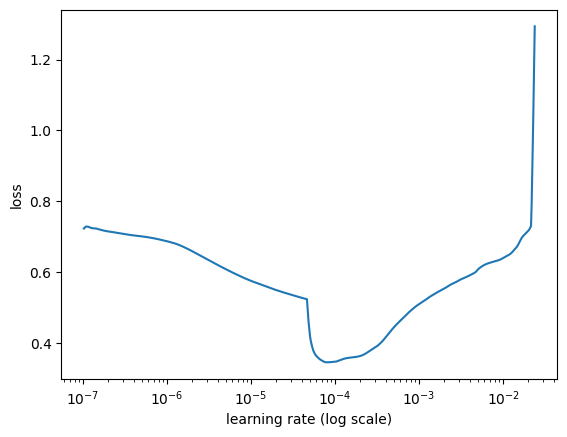

In [59]:
# plot loss vs learning rate to help identify the maximal learning rate associated with falling loss.
learner_bert.lr_plot()

The learning rate curve suggests that the highest learning rate resulting in a decrease in loss is around 1e-4.

In [60]:
# train the bert model
hist_bert = learner_bert.autofit(1e-4, checkpoint_folder='/content/drive/MyDrive/bert', epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
2555/2555 [==============================] - 1200s 462ms/step - loss: 0.3549 - accuracy: 0.8420 - val_loss: 0.2630 - val_accuracy: 0.8904
Epoch 2/12
2555/2555 [==============================] - 1176s 460ms/step - loss: 0.2511 - accuracy: 0.8968 - val_loss: 0.2472 - val_accuracy: 0.9014
Epoch 3/12
2555/2555 [==============================] - 1176s 460ms/step - loss: 0.1996 - accuracy: 0.9203 - val_loss: 0.2415 - val_accuracy: 0.9067
Epoch 4/12
2555/2555 [==============================] - 1176s 460ms/step - loss: 0.1573 - accuracy: 0.9401 - val_loss: 0.2545 - val_accuracy: 0.9133
Epoch 4: early stopping
Weights from best epoch have been loaded into model.


The BERT training converged quickly and achieved sufficient performance after 3 epochs, likely due to the maximal learning rate employed. It achieved a validation accuracy of 91% and a corresponding valuation loss of 0.2545, indicating good overall performance.

## Results & Analysis

This section dives into the results, summarizing key metrics and comparing the predictive capabilities of the models.

### Evaluate RNNs Training Process

To analyze the evolution of our RNN model's training process, we'll evaluate the performance of the best models saved at each training step. This will help us identify which training strategies were most effective.

In [37]:
# Load the best model for each training step
bst_mdl_bs_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_bs_RNN_weights_best.keras')
bst_mdl_h1_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_h1_RNN_weights_best.keras')
bst_mdl_h2_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_h2_RNN_weights_best.keras')
bst_mdl_h3_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_h3_RNN_weights_best.keras')
bst_mdl_h4_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_h4_RNN_weights_best.keras')
bst_mdl_h5_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_h5_RNN_weights_best.keras')
bst_mdl_h5ft_RNN = tf.keras.models.load_model('/content/drive/MyDrive/W6_mdl_h5ft_RNN_weights_best.keras')

#### Performance Analysis

In [38]:
# get the model scores against the test set
score_bs_RNN = bst_mdl_bs_RNN.evaluate(tf_test)
score_h1_RNN = bst_mdl_h1_RNN.evaluate(tf_test)
score_h2_RNN = bst_mdl_h2_RNN.evaluate(tf_test)
score_h3_RNN = bst_mdl_h3_RNN.evaluate(tf_test)
score_h4_RNN = bst_mdl_h4_RNN.evaluate(tf_test)
score_h5_RNN = bst_mdl_h5_RNN.evaluate(tf_test)
score_h5ft_RNN = bst_mdl_h5ft_RNN.evaluate(tf_test)

639/639 [==============================] - 9s 11ms/step - loss: 0.4181 - accuracy: 0.8470 - auc: 0.9147


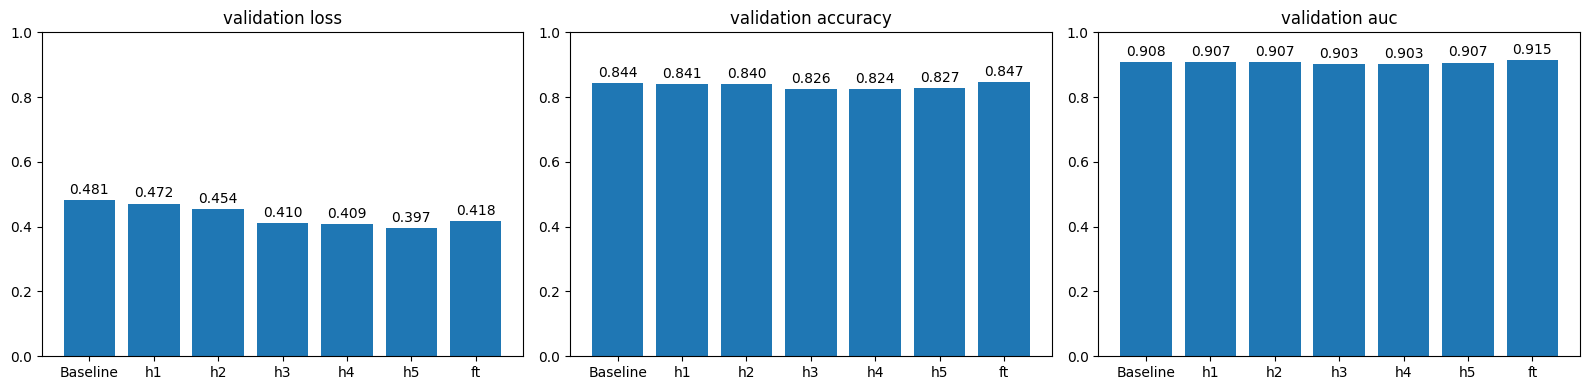

In [39]:
# plot the metrics
# list of model description
mdl_list = ['Baseline', 'h1', 'h2', 'h3', 'h4', 'h5', 'ft']
# metric list
metric_list = ['validation loss', 'validation accuracy', 'validation auc']

# set plot size
plt.figure(figsize=[16,4])
# plot each metric
for i in range(len(metric_list)):

  ### plot metric values
  plt.subplot(1,3,i+1)
  values = [score_bs_RNN[i], score_h1_RNN[i], score_h2_RNN[i], score_h3_RNN[i], score_h4_RNN[i], score_h5_RNN[i], score_h5ft_RNN[i]]
  plt.bar(range(len(mdl_list)), values, tick_label=mdl_list)

  # Add data values using bar_label
  for j, value in enumerate(values):
    plt.text(j, value + 0.01, f"{value:.3f}", ha='center', va='bottom', fontsize=10)
    # set the minimum and maximum values for the y-axis
  plt.ylim(0, 1)
  # print metric name as title
  plt.title(metric_list[i])

plt.tight_layout()
plt.show()

Despite achieving good validation accuracy and AUC, the baseline model suffered from overfitting, as indicated by the high validation loss. Implementing dropout regularization helped significantly reduce the validation loss as the regularization rate increased. However, this improvement in validation loss did not necessarily translate to better overall model performance.

By incorporating bidirectional layers and further optimizing the training settings, at the end, we were able to achieve a slight improvement in the overall model performance compared to the baseline model.

Consequently, while the overall model performance didn't improved significantly, the resulting model demonstrates robustness and generalizes well to unseen data without significant class bias. However, it's likely reached its capacity for further learning through the current training approach.

#### Training Time Analysis

Next, we'll examine the time it took to train each model.

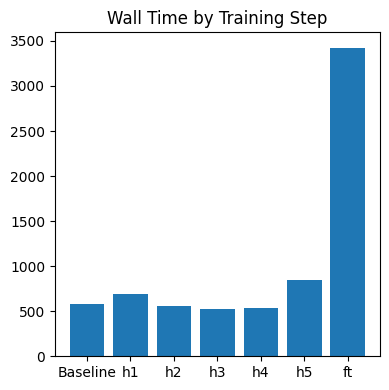

In [40]:
# Wall time in seconds for each model training taken manually
## manual inputs (H:MM:SS)
dur_bs_RNN = (9*60)+42
dur_h1_RNN = (11*60)+35
dur_h2_RNN = (9*60)+22
dur_h3_RNN = (8*60)+48
dur_h4_RNN = (8*60)+53
dur_h5_RNN = (14*60)+1
dur_h5ft_RNN = (57*60)+4

dur_list = [dur_bs_RNN, dur_h1_RNN, dur_h2_RNN, dur_h3_RNN, dur_h4_RNN, dur_h5_RNN, dur_h5ft_RNN]

## set plot size
plt.figure(figsize=[4,4])
names = mdl_list
values = dur_list
plt.bar(range(len(mdl_list)), values, tick_label=names)
plt.title('Wall Time by Training Step')

plt.tight_layout()
plt.show()

Interestingly, increasing the dropout rate had minimal impact on training time. In contrast, employing bidirectional layers nearly doubled it. While the initial performance of the bidirectional model fell short of its potential, subsequent fine-tuning yielded a slight improvement in overall performance. However, this came at the cost of a significant increase in training time.

#### Confusion Matrix Analysis

To gain deeper insights into RNN model performance, let's generate and compare confusion matrices for each training step model.

In [80]:
# predict each model class probabilities
y_prob_bs_RNN = bst_mdl_bs_RNN.predict(tf_test)
y_prob_h1_RNN = bst_mdl_h1_RNN.predict(tf_test)
y_prob_h2_RNN = bst_mdl_h2_RNN.predict(tf_test)
y_prob_h3_RNN = bst_mdl_h3_RNN.predict(tf_test)
y_prob_h4_RNN = bst_mdl_h4_RNN.predict(tf_test)
y_prob_h5_RNN = bst_mdl_h5_RNN.predict(tf_test)
y_prob_h5ft_RNN = bst_mdl_h5ft_RNN.predict(tf_test)

639/639 [==============================] - 8s 10ms/step


In [81]:
# convert probabilities to a binary class
y_pred_bs_RNN = np.where(y_prob_bs_RNN > 0.5, 1, 0)
y_pred_h1_RNN = np.where(y_prob_h1_RNN > 0.5, 1, 0)
y_pred_h2_RNN = np.where(y_prob_h2_RNN > 0.5, 1, 0)
y_pred_h3_RNN = np.where(y_prob_h3_RNN > 0.5, 1, 0)
y_pred_h4_RNN = np.where(y_prob_h4_RNN > 0.5, 1, 0)
y_pred_h5_RNN = np.where(y_prob_h5_RNN > 0.5, 1, 0)
y_pred_h5ft_RNN = np.where(y_prob_h5ft_RNN > 0.5, 1, 0)

y_pred_list = [y_pred_bs_RNN, y_pred_h1_RNN, y_pred_h2_RNN, y_pred_h3_RNN, y_pred_h4_RNN, y_pred_h5_RNN, y_pred_h5ft_RNN]
y_true = df_test['target']

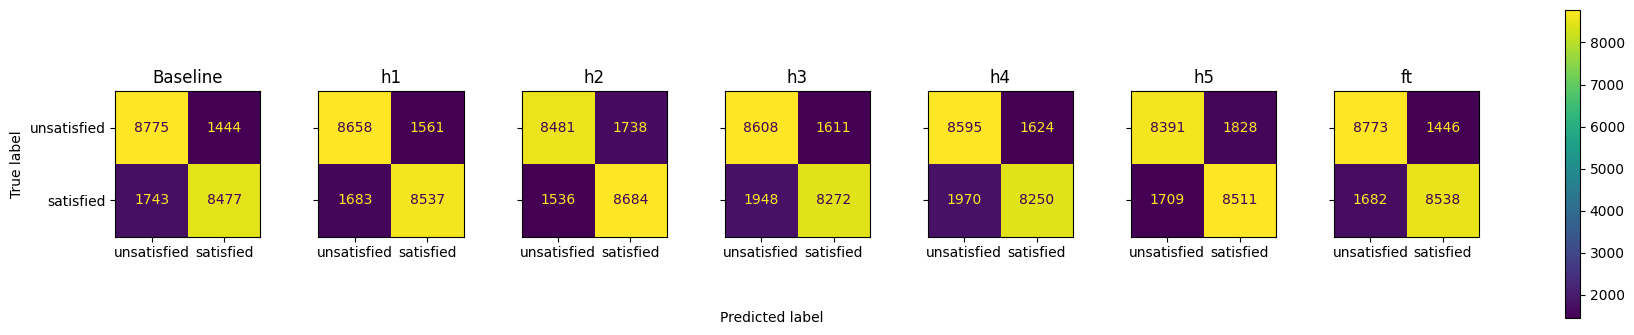

In [75]:
warnings.filterwarnings('ignore')

# set plot settings
f, axes = plt.subplots(1, 7, figsize=(22, 4), sharey='row')

# itirate across RNN models
for i, y_pred in enumerate(y_pred_list):
  cf_matrix = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cf_matrix, display_labels=['unsatisfied', 'satisfied'])
  disp.plot(ax=axes[i])
  disp.ax_.set_title(mdl_list[i])
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

The confusion matrices confirm our earlier findings that dropout regularization effectively mitigated overfitting, and prevented to model into getting bias against to particular class.

The final model demonstrates significantly better class discrimination compared to the baseline, evident in the reduced number of false negatives within the confusion matrix. This suggests the model is less likely to misclassify actual `satisfied` cases.

Furthermore, the balanced distribution of true negatives and false positives implies the model has learned well from the available data using the tuned hyperparameters. This fine-tuning likely enhanced the model's ability to distinguish between classes.

### Evaluate the RNN-Based Model Overall Performance

In this section, we will summarize the RNN-based model overall predictive performance.

In [93]:
from sklearn.metrics import classification_report

# print a text report showing the RNN-base model main classification metrics
print(classification_report(y_true, y_pred_h5ft_RNN, target_names=['unsatisfied', 'satisfied']))

              precision    recall  f1-score   support

 unsatisfied       0.84      0.86      0.85     10219
   satisfied       0.86      0.84      0.85     10220

    accuracy                           0.85     20439
   macro avg       0.85      0.85      0.85     20439
weighted avg       0.85      0.85      0.85     20439



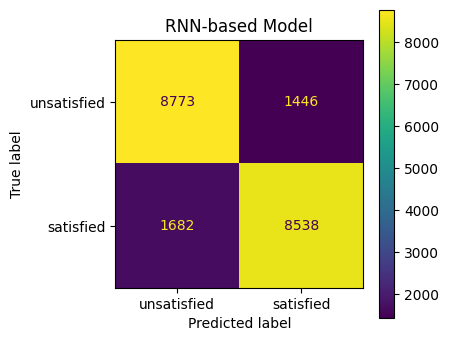

In [94]:
# display the RNN-based model confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
cf_matrix = confusion_matrix(y_true, y_pred_h5ft_RNN)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['unsatisfied', 'satisfied'])
disp.plot(ax=ax)
disp.ax_.set_title('RNN-based Model')
plt.show()

With an accuracy of 85% and a matching F1-score of 85%, the RNN-based model effectively distinguished `satisfied` and `unsatisfied` sentiments in validation data. Its high F1-score indicates a great balance between the model's ability to correctly identify `satisfied` and `unsatisfied` reviews.

### Evaluate the BERT-Based Overall Model Performance

In this section, we will summarize the BERT-based model overall predictive performance.

In [41]:
### Upload the weights of the best BERT model ###
# clear keras backend
tf.keras.backend.clear_session()

# transform pd dataframes to ktrain datasets
bert_train, bert_val, bert_preproc = texts_from_df(
                                          train_df = df_train,
                                          text_column = 'text',
                                          label_columns=['satisfaction'],
                                          val_df = df_test,
                                          max_features=50000,
                                          maxlen=120,
                                          ngram_range=2,
                                          preprocess_mode='bert',
                                          is_regression = False,
                                          random_state = 42,
                                          verbose=1)

# create the bert classifier
mdl_bert = text.text_classifier('bert', bert_train, preproc=bert_preproc)

# upload saved weights
mdl_bert.load_weights('/content/drive/MyDrive/bert/weights-03-0.24.hdf5')

# create the learner instance
learner_bert = ktrain.get_learner(mdl_bert, train_data=bert_train, val_data=bert_val, batch_size=32)

['satisfied', 'unsatisfied']
        satisfied  unsatisfied
176048        1.0          0.0
33492         0.0          1.0
5798          1.0          0.0
24352         1.0          0.0
67795         1.0          0.0
['satisfied', 'unsatisfied']
        satisfied  unsatisfied
50372         1.0          0.0
83237         1.0          0.0
137585        1.0          0.0
205147        0.0          1.0
178533        0.0          1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 120
done.


In [92]:
# print a text report showing the BERT-base model main classification metrics
rpt_bert = learner_bert.validate(val_data=bert_val, print_report=True, class_names=['unsatisfied', 'satisfied'])

639/639 [==============================] - 86s 135ms/step
              precision    recall  f1-score   support

 unsatisfied       0.91      0.90      0.91     10220
   satisfied       0.90      0.91      0.91     10219

    accuracy                           0.91     20439
   macro avg       0.91      0.91      0.91     20439
weighted avg       0.91      0.91      0.91     20439



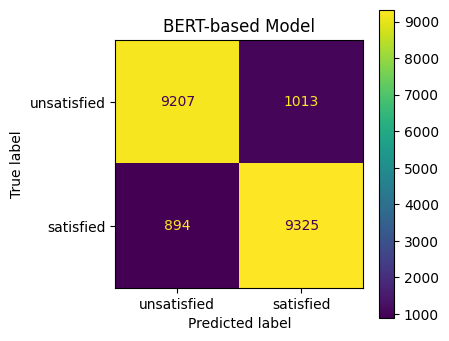

In [95]:
# display the BERT-based model confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=rpt_bert, display_labels=['unsatisfied', 'satisfied'])
disp.plot(ax=ax)
disp.ax_.set_title('BERT-based Model')
plt.show()

The BERT-based model has achieved an impressive accuracy of 91% in sentiment analysis. This is accompanied by a similarly high F1-score of 91%, indicating a strong balance between precision and recall. These results suggest that the model can effectively distinguish `satisfied` and `unsatisfied` sentiments within the test data.

### Model Comparison Analysis: RNN vs. BERT

Based on our results, the BERT-based model outperforms the RNN-based model for sentiment analysis.

| Metric | RNN Model | BERT Model |
|---|---|---|
| Accuracy | 85% | 91%|
| F1-Score | 85% | 91% |

BERT achieves a significantly higher accuracy (6% difference), indicating it correctly classifies a larger proportion of user reviews. Similar to accuracy, BERT's higher F1-score suggests it strikes a better balance between precision and recall in user review classification.

The higher accuracy and F1-score of the BERT model suggest it has a better ability to capture the nuances of sentiment within the user reviews compared to the RNN model.

## Conclusion

This project explored the use of Recurrent Neural Networks (RNNs) and Bidirectional Encoder Representations from Transformers (BERT) for sentiment analysis of user reviews focused on overall drug satisfaction. The goal was to develop a model that automatically extracts this sentiment from the reviews, potentially aiding healthcare providers in understanding patient experiences with medications.

During the exploration and data analysis phase, we performed several key steps to improve the model's performance:

* Dimensionality reduction: We removed feature variables that lacked predictive power for the sentiment classification task.
* Target variable encoding: The ranking variable was encoded into a sentiment variable containing two classes: `satisfied` and `unsatisfied.`
* Class imbalance: The training data exhibited an uneven class distribution, where one sentiment might have significantly more instances than the other. To address this, we applied random undersampling.
* Noise reduction: We removed those instances where the user review exceeded 200 words or it was less than 10 words.

In addition, we employed Term Frequency-Inverse Document Frequency (TF-IDF) to analyze the most important words associated with each sentiment class (`satisfied` and `unsatisfied`). However, our analysis revealed that there were no clear, single keywords that definitively indicated a specific sentiment. This suggests that sentiment in drug reviews is likely conveyed through a combination of words and their context within the reviews, highlighting the importance of models like RNN and BERT which can capture these nuances.

During the training process, we encountered a challenge with the baseline RNN model. It exhibited a tendency to overfit the training data. To address this issue, we implemented `Dropout` regularization. We experimented with different dropout rates upto we found the optimal setting that reduced the RNN model overfitting. Finally, with overfitting under control, we added bidirectional layers, and fine-tuned the model with lower learning rates to unlock additional performance improvements.

Our results revealed that the BERT model achieved superior performance. It achieved an accuracy of 91% and a corresponding F1-score of 91%, significantly outperforming the RNN model with its 85% accuracy and 85% F1-score. This is likely because BERT can grasp better the nuances of user experiences expressed in reviews.

While the results showcase the potential of RNNs and BERTs in sentiment analysis of user reviews, there's room for further optimization. With more time, we could explore different RNN architectures, use of other available pre-trained BERTHs (i.e., Distilbert), or experimenting with different word enconding techniques (i.e., Fasttext).